<img src="./desert.jpg" />

# Irrigating the Food Desert

Presented below is a brief introductory analysis of the Food Access Research Atlas provided by the Economic Research Service of the United States Department of Agriculture (https://www.ers.usda.gov/data-products/food-access-research-atlas/).  The overarching goal of this work is to identify the main factors that inhibit healthy eating in a given county in the US and lead to obesity.  This is a complicated problem and the main contributors to unhealthy eating change depending on how developed a county is, its demographics, and socioeconomic factors.  This dataset includes many characteristics of the counties in the US including the types of food sources, the percentage on SNAP, the food security, and agricultural statistics.  Here, we will look at the overall trends in the US, the dependence of obesity rates on the types of stores and restaurants available, and the dependence high school activity level on the presence of farm-to-school programs in schools.  We will also use the Atlas of Rural and Small-town America (https://www.ers.usda.gov/data-products/atlas-of-rural-and-small-town-america/).

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.plotly as py
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from DL_setup import *
from DL_model import *
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

/Users/jameshogg/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [2]:
# Load data and combine

xls = pd.ExcelFile('./DataDownload.xls')
access_sheet = pd.read_excel(xls, 'ACCESS')
stores_sheet = pd.read_excel(xls, 'STORES')
restaurants_sheet = pd.read_excel(xls, 'RESTAURANTS')
assistance_sheet = pd.read_excel(xls, 'ASSISTANCE')
insecurity_sheet = pd.read_excel(xls, 'INSECURITY')
prices_sheet = pd.read_excel(xls, 'PRICES_TAXES')
local_sheet = pd.read_excel(xls, 'LOCAL')
health_sheet = pd.read_excel(xls, 'HEALTH')
socioeconomic_sheet = pd.read_excel(xls, 'SOCIOECONOMIC')

rxls = pd.ExcelFile('./RuralAtlasData18.xls')
rural_sheet = pd.read_excel(rxls, 'County Classifications')
data = pd.concat([access_sheet, 
                  stores_sheet, 
                  restaurants_sheet, 
                  assistance_sheet, 
                  insecurity_sheet,
                  prices_sheet,
                  local_sheet,
                  health_sheet,
                 socioeconomic_sheet,
                  rural_sheet
                 ], axis=1)
data = data.T.drop_duplicates().T


Let's start by simply plotting the counties and their obesity rates.

In [3]:
# Make choropleth plot of obesity rates

data_plot = data[['FIPS', 'PCT_OBESE_ADULTS13']].dropna(how='any')
fips = data_plot['FIPS'].values.tolist()

values = data_plot['PCT_OBESE_ADULTS13'].values.tolist()

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(20, 45, len(colorscale) - 1))

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='Percent of Obese Adults Per County %',
    legend_title='% Obese'
)
py.iplot(fig)

The draw time for this plot will be slow for clients without much RAM.


There are many interesting features that appear in this map.  Firstly, many of the counties with higher obesity rates are found in the southeast, "Appalachia" in West Virginia and Kentucky, and the "Breadbasket" of America in states like Kansas, Missouri, and Arkansas.  There are also pockets of increased obesity rates in states like South Dakota and Montana.  Alaska and Hawaii are not included in this map, but are included in the analysis.  There are hints that state legislation may be a factor as you can make out states like Colorado and Texas from neighboring states.

Let's first do a simple numerical investigation into the dependences with a linear fit to the obesity rate based on the prevalence of different types of food sources.  We will divide the data into metropolitan and non-metropolitan counties since the lifestyles of these two types of counties can be quite different.  In order, the variables we will compare against are the percentage of the population with no vehicle and low access to grocery stores, the number of grocery stores per thousand people, the number of supercenters per thousand people, the number of convenience stores per thousand people, the number of specialty food stores per thousand people, the number of fast food stores per thousand people, and the number of full service restaurants per thousand people.

In [4]:
fields = ['PCT_LACCESS_HHNV15', 
          'GROCPTH14',
          'SUPERCPTH14',
          'CONVSPTH14',
          'SPECSPTH14',
          'FFRPTH14',
          'FSRPTH14',
          'PCT_OBESE_ADULTS13']

metro_data = data[data['METRO13']==1][fields].dropna(how='any')
non_metro_data = data[data['METRO13']==0][fields].dropna(how='any')

In [5]:
metro_model=LinearRegression()
metro_model.fit(metro_data[fields[:-1]],metro_data['PCT_OBESE_ADULTS13'])
print 'Regression Coefficients for Metro Areas:'
pd.DataFrame(zip(fields,metro_model.coef_))

Regression Coefficients for Metro Areas:


,0,1
0,PCT_LACCESS_HHNV15,0.743448
1,GROCPTH14,0.280917
2,SUPERCPTH14,47.431904
3,CONVSPTH14,5.742615
4,SPECSPTH14,-3.063074
5,FFRPTH14,0.127192
6,FSRPTH14,-3.800109


In [6]:
non_metro_model=LinearRegression()
non_metro_model.fit(non_metro_data[fields[:-1]],non_metro_data['PCT_OBESE_ADULTS13'])
print 'Regression Coefficients for Non-Metro Areas:'
pd.DataFrame(zip(fields,non_metro_model.coef_))

Regression Coefficients for Non-Metro Areas:


,0,1
0,PCT_LACCESS_HHNV15,0.215149
1,GROCPTH14,-1.525068
2,SUPERCPTH14,12.955739
3,CONVSPTH14,1.480040
4,SPECSPTH14,-2.215563
5,FFRPTH14,-0.566527
6,FSRPTH14,-2.364518


In both types of area the number of supercenters like Wal-Mart or Costco was a good predictor of obesity rates.  In less metropolitan areas the enhanced presence of grocery stores and specialty food stores played a larger role in decreasing obesity.  In metropolitan areas convenience stores seem to contribute to higher obesity rates than in less metropolitan areas.  In all, these results suggest that the two types of areas are distinct and that to get meaningful results that can be implemented in lowering the obesity rate, we must remain cognizant of the diversity of the areas we are considering.  Considering additional features of the area like socioeconomics and other characteristics of the populations motivates a more rigorous approach, like a deep learning model, that can capture the nuances of the dataset.

It is important to instill the value of health into the younger generations so that good habits that last a lifetime are learned early.  Links between childhood obesity and adult obesity are well-established, so children who lead an unhealthly lifestyle will suffer from poor quality of life and elevated medical bills in adulthood.  By looking at the relationship between the percentage of physically active high schoolers in metropolitan and non-metropolitan areas in schools where farm to school programs are operated, we can see the diversity of the populations within our dataset.  This further demonstrates how beneficial solutions to this hard problem can only come from a careful and flexible analysis of the underlying problems.

In [7]:
fields = ['FARM_TO_SCHOOL13',
          'PCT_HSPA15',
          'UrbanInfluenceCode2003']
youth_activity_data = data[fields].dropna(how='any').astype(float)
youth_activity_data['Metro Status'] = youth_activity_data['UrbanInfluenceCode2003'] >= 3

Number of counties:
Farm to school programs in urban areas 740
No farm to school programs in urban areas 486
Farm to school programs in rural areas 433
No farm to school programs in rural areas 228


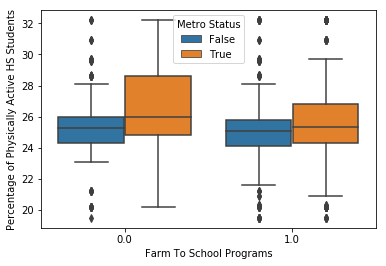

In [8]:
print 'Number of counties:'
print 'Farm to school programs in urban areas', youth_activity_data[(youth_activity_data['FARM_TO_SCHOOL13'] == 1) & (youth_activity_data['Metro Status'] == True)].shape[0]
print 'No farm to school programs in urban areas', youth_activity_data[(youth_activity_data['FARM_TO_SCHOOL13'] == 0) & (youth_activity_data['Metro Status'] == True)].shape[0]
print 'Farm to school programs in rural areas', youth_activity_data[(youth_activity_data['FARM_TO_SCHOOL13'] == 1) & (youth_activity_data['Metro Status'] == False)].shape[0]
print 'No farm to school programs in rural areas', youth_activity_data[(youth_activity_data['FARM_TO_SCHOOL13'] == 0) & (youth_activity_data['Metro Status'] == False)].shape[0]

fig, ax = plt.subplots(1,1)
sns.boxplot(youth_activity_data['FARM_TO_SCHOOL13'], youth_activity_data['PCT_HSPA15'], hue=youth_activity_data['Metro Status'])
ax.set_xlabel('Farm To School Programs')
ax.set_ylabel('Percentage of Physically Active HS Students');

This plot is not meant to establish any correlations, but rather just to highlight the types of populations within the counties in the U.S.  In general the average percentage of physically active high schoolers is consistent across the four groups.  In non-metropolitan metropolitan counties the groups with and without farm-to-school programs have similar distributions in physical activity, albeit the distribution of the counties without farm to school programs is truncated at low percentages of activity levels.  Between the two groups of students in metropolitan areas, however, the two populations seem distinct.  The activity levels of students in counties without farm-to-school programs is skewed to higher values as seen in the upper three quartiles of the distribution.  It also does have a longer tail to low levels of inactivity.  Additional analysis can help understand what motivates teens to be active to encourage the behavior while also understanding what leads to inactivity.

It is well known the obesity epidemic disproportionately affects the most vulnerable populations because fresh, healthy foods are more expensive than readily available, heavily processed foods.  This leads to a moderate correlation with poverty rate.  This can be particularly be seen in the extremities of the poverty distribution where the counties with the lowest poverty rates have the lowest obesity rates and the highest obesity rates are found in counties with the highest poverty rates.

Pearson-r value:  0.40766808287286493


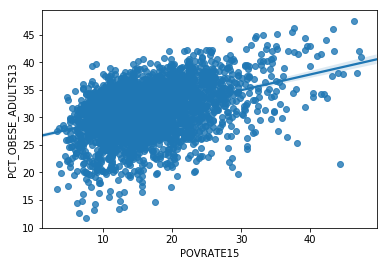

In [9]:
fields = ['POVRATE15',
          'PCT_OBESE_ADULTS13']

poverty = data[fields].dropna(how='any').astype(float)

sns.regplot(poverty['POVRATE15'], poverty['PCT_OBESE_ADULTS13'])
print 'Pearson-r value: ', np.corrcoef(poverty['POVRATE15'], poverty['PCT_OBESE_ADULTS13'])[0,1]

There is no clear cause of obesity in this dataset, rather it is the culmination of many weakly correlated factors.  As you slice the data and search for correlations between different variables, correlations often are found at linear correlation coefficients, as measured by the Pearson-r statistic, at the r=0.3-0.5 level.  An example of this is related to soda consumption.  One common way to encourage consumers to avoid unhealthy food is to add additional tax to the products.  Soda is a large culprit in the obesity crisis because it is high in sugar and, quite frankly, delicious.  Looking at the case of taxes on this product, on the surface it does not appear that increased taxes lower the obesity rates.  For each level of tax the obesity rate spans a wide range. 

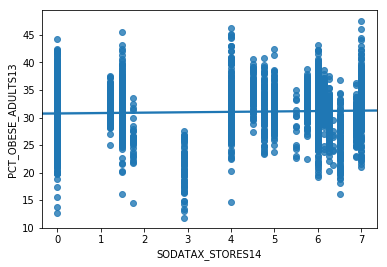

In [10]:
fields = ['SODATAX_STORES14',
          'SODA_PRICE10',
          'PCT_OBESE_ADULTS13']

soda = data[fields].dropna(how='any').astype(float)
sns.regplot(soda['SODATAX_STORES14'], soda['PCT_OBESE_ADULTS13']);

Looking at the relationship between the actual price of soda in a county relative to the national average compared to the obesity rate, there is a hint of a weak anticorrelation, but it is not enough to motivate increasing prices as a clear way of addressing the problem.

Pearson-r value:  -0.267483350645051


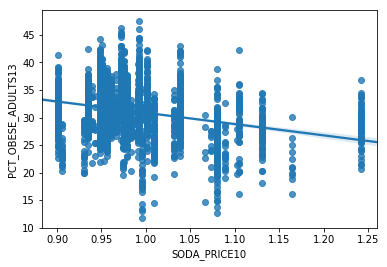

In [11]:
sns.regplot(soda['SODA_PRICE10'], soda['PCT_OBESE_ADULTS13'])
print 'Pearson-r value: ', np.corrcoef(soda['SODA_PRICE10'], soda['PCT_OBESE_ADULTS13'])[0,1]

The nuance of the dataset makes it difficult to pull out insight using standard methods and is difficult even with normal machine learning approaches.  It is well-suited, though, for deep learning where the data is passed through successive layers that extract increasingly subtle features.  Currently, the model predicts the obesity rate by treating it as a regression problem and has an input layer composed of neurons totaling the number of inputs (28), a single hidden layer, and a one neuron output layer.  The rectified linear activation function is used for activation in the input and hidden layers.

In [12]:
DL_model(data)

Total predictors:  28
Individual cross validation results:  [-11.94333332 -10.66457086 -11.38944783 -10.35006396  -8.557458  ]
Results: -10.58 (1.15) MSE


As it stands, the model accurately predicts obesity rates within a given county to roughly 3 percent.  I plan to increase the accuracy of the model by including additional data like a finer classification of its metropolitan status and more detailed descriptions of its public transportation as it relates to accessibility.

Once developed, the model will serve as a basis for a web application where municipalities can get ideas for targeted areas to address in order to fight obesity in their county tailored to their needs.  For these suggestions, I will effectively "turn the knobs" of the county to see how they can best improve access to healthy food. For instance, in some areas more farmers markets may be the most effective solutions while in others it may be better recreational facilities.  Knowing what the most important factors are will aid in directing resources effectively.  Additionally, as part of the web application, a clustering algorithm will determine similar counties.  This will enable communication and sharing what programs or initiatives are most effective.